In [2]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/ccpg44dt73ga24p45a0u3/collaborations_Zoology_608.csv.gz?rlkey=8kr35ztwfztz36qww7v1fr926&st=xcxd6s6d&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1100184428,2018.0,ur.07500112735.28
1,pub.1100184428,2018.0,ur.0775274140.76
2,pub.1014429482,2008.0,ur.012645135765.17
3,pub.1014429482,2008.0,ur.016413706041.84
4,pub.1071171019,1994.0,ur.01216432663.31
...,...,...,...
1134648,pub.1028766873,2008.0,ur.0747722674.67
1134649,pub.1063382447,2016.0,ur.01114402740.30
1134650,pub.1063382447,2016.0,ur.01137537003.00
1134651,pub.1063382447,2016.0,ur.0577704134.35


In [4]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/0bsgnsgb1rr1s143cgyd1/articles_Zoology_608.csv.gz?rlkey=emlv5fy52dz0d2rnodygjy9pp&st=kehlrig7&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_44915/2360218702.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

# Concept Data
The concept data is mostly what we'll be working with. It's available in the "dimensions_2021_09_01_pull_1/concept_network_data" folder for different fields and the "applied_mathematics_piloting/articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz" file for just the applied mathematics field.

Each row represents a concept that occurs in a specific paper. It has the following columns:

| Column | Meaning |
| --- | --- |
| `article_id` | Unique identifier for each article. Same as the other files to merge on. |
| `year` | Article's year of publication |
| `concept` | The concept that shows up in the article's abstract |
| `relevance_mean` | Each occurrence of a concept has a relevance score between 0 and 1 for how associated it is with the text around it. This is the mean of that score across all occurrences. |
| `concept_freq_in_abstract` | The number of times that concept shows up in the paper's abstract. |
| `concept_no` | The number of concepts before it in that paper's abstract |
| `dfreq_in_category_for_2l` | The number of times that concept shows up in the field |
| `dfreq_in_category_for_2l_year` | The number of times that concept shows up in the field in that year |

We primarily use the first 4.

In [5]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ciu77f72&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1050083629,1984,mfvsg,0.0,1,0,2,1
1,pub.1050083629,1984,svsg,0.0,1,1,1,1
2,pub.1091469564,1992,1972 random parasitoid model,0.0,1,0,1,1
3,pub.1117742847,2001,198697 lobster research cruise,0.0,1,0,1,1
4,pub.1043257859,2001,1986–97 lobster research cruise,0.0,1,0,2,2
...,...,...,...,...,...,...,...,...
18064866,pub.1000238039,2015,’s worker population size,0.0,1,40,1,1
18064867,pub.1005449634,2012,’s workforce swarm fraction depart,0.0,1,42,1,1
18064868,pub.1134463678,2021,’s bad crop pest,0.0,1,57,1,1
18064869,pub.1083920773,2017,’s bad invasive,0.0,1,54,1,1


In [6]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
18622,pub.1039451177,akh receptor,2002
18623,pub.1129686695,akh receptor,2020
18624,pub.1007326462,akh receptor,2006
18625,pub.1101015253,akh receptor,2018
49772,pub.1092160858,acromyrmex leaf cut ant,2017
...,...,...,...
18063221,pub.1010904311,γδ t cell,2012
18063223,pub.1039368032,γδ t cell,2014
18063225,pub.1120146611,γδ t cell,2019
18063226,pub.1040144066,γδ t cell,2012


## Network Nodes
Concepts are nodes in the network. Each concept has a weight, which comes from the normalized year the concept initially is published in. We normalize using
$$
    n_i = \frac{y_i - y_{\min}}{y_{\max} - y_{\max}}.
$$

In [9]:
# get the last publication
concepts_first = (
    df
        .sort_values('year')
        .drop_duplicates(subset='concept', keep='first')#keep fisrt
        .reset_index(drop=True)
)
concepts_last = (
    df
        .sort_values('year')
        .drop_duplicates(subset='concept', keep='last')  #keep last
        .reset_index(drop=True)
)

# normalize the year
concepts_first['norm_year'] = (concepts_first['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
#concepts['last_norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
concepts_last['norm_year'] = (concepts_last['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

print(concepts_first)
print(concepts_last)

          article_id                        concept  year  norm_year
0     pub.1070547478                      land bird  1920   0.000000
1     pub.1005636163                     fruit tree  1921   0.009901
2     pub.1070548561                american museum  1922   0.019802
3     pub.1070548072              bird conservation  1922   0.019802
4     pub.1054807332        ministry of agriculture  1923   0.029703
...              ...                            ...   ...        ...
4141  pub.1122800167    free plain language summary  2019   0.980198
4142  pub.1112852989  sustainable development goals  2019   0.980198
4143  pub.1125125078     invasive non native specie  2020   0.990099
4144  pub.1131427185               student learning  2020   0.990099
4145  pub.1125090234    hermetic storage technology  2020   0.990099

[4146 rows x 4 columns]
          article_id                    concept  year  norm_year
0     pub.1050740824          museum expedition  1935   0.148515
1     pub.1050740

In [10]:
first = concepts_first.set_index('concept')
last = concepts_last.set_index('concept')

# merge to lifespan
concept_span = pd.DataFrame({
    'first_year': first['year'],
    'last_year': last['year']
})

concept_span['lifespan'] = concept_span['last_year'] - concept_span['first_year']

concept_span['first_norm'] = first['norm_year']
concept_span['last_norm'] = last['norm_year']

#sorting
concept_span_sorted = concept_span.sort_values(by='lifespan', ascending=True)

#print
concept_span_sorted

,first_year,last_year,lifespan,first_norm,last_norm
concept,,,,,
solid state nmr,2018,2018,0,0.970297,0.970297
vertebrate characteristic,2009,2009,0,0.881188,0.881188
virescens larvae,2008,2008,0,0.871287,0.871287
south east atlantic ocean,2006,2006,0,0.851485,0.851485
true vertebrate characteristic,2009,2009,0,0.881188,0.881188
...,...,...,...,...,...
field crop,1923,2020,97,0.029703,0.990099
wild mammal,1924,2021,97,0.039604,1.000000
bird conservation,1922,2020,98,0.019802,0.990099


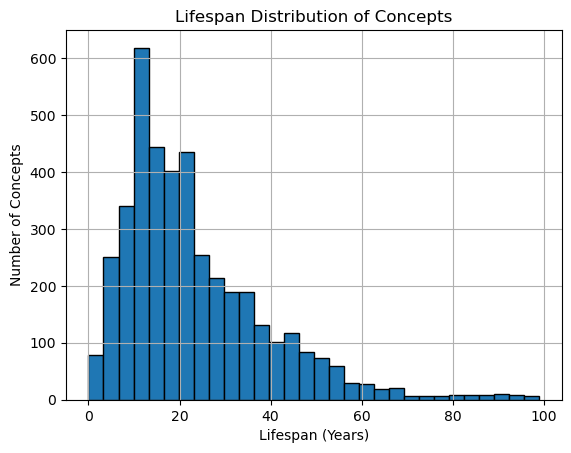

In [11]:
plt.hist(concept_span['lifespan'], bins=30, edgecolor='black')
plt.title('Lifespan Distribution of Concepts')
plt.xlabel('Lifespan (Years)')
plt.ylabel('Number of Concepts')
plt.grid(True)
plt.show()


## Network Edges
Get the edges of the network by merging the dataframe in on itself. Then, we again keep only the first occurrence and normalize the year.

In [14]:
lifespan_dict = concept_span['lifespan'].to_dict()
edges = df.merge(df, on='article_id', suffixes=['_source', '_target'])
edges = edges[edges['concept_source'] < edges['concept_target']]
edges = edges[['concept_source', 'concept_target']].drop_duplicates().copy()

edges['lifespan_source'] = edges['concept_source'].map(lifespan_dict)
edges['lifespan_target'] = edges['concept_target'].map(lifespan_dict)

edges['lifespan'] = edges[['lifespan_source', 'lifespan_target']].max(axis=1)
edges


,concept_source,concept_target,lifespan_source,lifespan_target,lifespan
6,acromyrmex leaf cut ant,developmental stage,15,21,21
9,acromyrmex leaf cut ant,caste specific expression,15,9,15
10,acromyrmex leaf cut ant,colony level selection,15,22,22
11,acromyrmex leaf cut ant,genetic variation,15,33,33
12,acromyrmex leaf cut ant,social insect caste,15,12,15
...,...,...,...,...,...
86601,wood bore beetle,wood bore insect,11,21,21
86656,worker bee,worker larvae,47,34,47
86776,worker reproduction,young larvae,21,85,85
86803,worker reproduction,worker sterility,21,19,21


## Knowledge Network
Make the network using the dataframes.

There are other ways to do this (Networkx can make a network from a pandas edgelist or we could make a bipartite article-concept network and wrap it in on itself), but this is fastest in my experience without losing isolate nodes.

In [ ]:
# initialize the graph
G = nx.Graph()

# add the nodes
G.add_nodes_from([(c, {'weight': ny}) for c, ny in zip(concepts['concept'], concepts['norm_year'])])


# add the edges
G.add_edges_from([(u, v, {'weight': ny}) for u, v, ny in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'])])

G

In [ ]:
adj = nx.adjacency_matrix(G, weight='weight')

## Next Steps
Next, you can plug the network into the homology pipeline and calculate persistence. You could also do any other network analysis on it (centrality, communities, etc.).

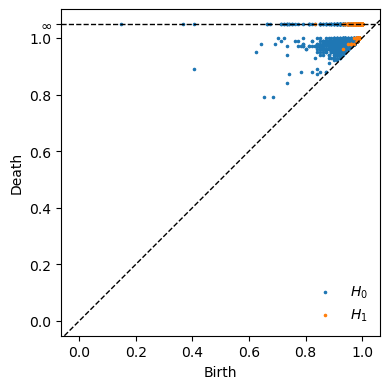

In [ ]:
import oat_python as oat

# adjacency matrix
adj = nx.adjacency_matrix(G)
adj.setdiag([d['weight'] for _, d in G.nodes(data=True)])
adj = adj.sorted_indices()

# oat calculation
factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
homology = factored.homology(False, False)

# initialize the plot
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(4)
infty = 1.05
ax.set_xlabel('Birth')
ax.set_ylabel('Death')
ax.axis('equal')

# lines
ax.axhline(infty, ls='--', c='k', lw=1)
ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

# loop, plot homology
for dim in homology['dimension'].unique():
    dim_bc = homology[homology['dimension'] == dim]
    ax.scatter(dim_bc['birth'], dim_bc['death'].replace(np.inf, infty), s=2.5, label=f'$H_{dim}$')

# final formatting
ticks = ax.get_yticklabels()[1:-1]
ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
ax.set_yticklabels(ticks)
ax.legend(frameon=False)
fig.tight_layout()
handles = ax.get_legend_handles_labels()